## Options

- rerun XGB from old version to confirm high score then re-tune and run with extremely low learning rate
- replicate stacked then averaged but simplify not to use stacked
- Try Bayesian ??? long runtime?


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# set Jupyter to display ALL output from a cell (not just last output)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# set pandas and numpy options to make print format nicer
pd.set_option("display.width",100)
pd.set_option("display.max_columns",1000)
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.max_rows', 500)
np.set_printoptions(linewidth=100, threshold=5000, edgeitems=10, suppress=True)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train_orig = pd.read_csv('train.csv')
test_orig  = pd.read_csv('test.csv')

total = pd.concat([train_orig, test_orig], axis=0).reset_index(drop=True)  # ensure common columns
num_train = train_orig.shape[0]

# remove columns that are all ones or all zeroes
cols = []  # maybe drop ID columns as there 'shouldnt' be meaning to it???
cols = np.append(cols, total.columns[(total[:num_train] == 0).all()].values) # all zeroes cols in train
cols = np.append(cols, total.columns[(total[:num_train] == 1).all()].values) # all ones cols in train
cols = np.append(cols, total.columns[(total[num_train:] == 0).all()].values) # all zeroes cols in test
cols = np.append(cols, total.columns[(total[num_train:] == 1).all()].values) # all ones cols in test
print('Dropping constant columns:\n', cols)
total.drop(cols, axis=1, inplace=True)  # remove columns if there is no training data

# remove outliers - extensive testing showed very tiny improvement at cutoff 144
outliers = total[total.y > 155].index # should be 180
total.drop(outliers, axis=0, inplace=True)
num_train -= len(outliers)

# remove columns that are duplicated in the training set
# temp = total[:num_train].copy().T
# duplicates = temp[temp.duplicated()].index
# print('Dropping duplicate columns:\n', duplicates.values)
# total.drop(duplicates, axis=1, errors='ignore', inplace=True)

#remove correlated columns - commented out as this makes submission for XGB about 0.5% worse!
# cor = total.drop('y',1).corr().abs()
# cor.values[[np.arange(len(cor))]*2] = 0 # fill diagonal with zeroes
# cor = cor.where(np.triu(np.ones(cor.shape)).astype(np.bool)).fillna(0) # get upper triangle only
# cor_columns = []; cor_values = []
# for col in cor.columns:
#     if cor[col].max() > 0.99:
#         #print('Found', col, cor[col].argmax(), cor[col].max())
#         cor_columns.append(col)
#         cor_values.append(cor[col].max())
# print('Corellated columns to be dropped:',len(cor_values),'\n', sorted(cor_columns), cor_values)
#total.drop(cor_columns, axis=1, inplace=True)

# le = LabelEncoder() # didnt improve xgboost results
# for cat in categorical:
#     total[cat] = le.fit_transform(total[cat]) # transform categoricals to numerical - bad!

# convert categorical columns to one-hot encoding
categorical = [col for col in total.columns if total[col].dtype == object]  # change categorical to dummies
print('Changing', categorical, 'to categorical')
total = pd.get_dummies(total, columns=categorical)

Xtest = total[num_train:].drop('y',1)    # drop y from test (as clearly all NAs)

def create_data(data, random_state=0):
    train = data.copy()

    # replace all duplicates with a row as the mean of the duplicate
#     cols = list(train.drop(['ID','y'], 1).columns)
#     train_gb = train.groupby(cols, as_index=False)
#     print('Aggregating/averaging rows for the same config:')
#     train  = train_gb.mean()
#     for i, row in enumerate(train_gb): # add detailed columns showing all IDs, and all y's aggregated
#         train.loc[i, 'ID'] = ', '.join(row[1].ID.astype(str))
#        train.loc[i, 'ys'] = ', '.join(row[1].y.astype(str))
#    train.sort_values('ID', inplace=True)

    Xtrain, Xvalid, ytrain, yvalid = train_test_split(train.drop(['y','ys'],1, errors='ignore'), train.y, 
                                                      test_size=0.2, random_state=random_state)
    return Xtrain, ytrain, Xvalid, yvalid

Xtrain, ytrain, Xvalid, yvalid = create_data(total[:num_train], random_state=0)
print('DONE!!!')

Dropping constant columns:
 ['X107' 'X11' 'X233' 'X235' 'X268' 'X289' 'X290' 'X293' 'X297' 'X330' 'X347' 'X93' 'X257' 'X258'
 'X295' 'X296' 'X369']
Changing ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'] to categorical
DONE!!!


In [6]:
from sklearn.metrics import r2_score

def fitit(model, saveit=True):
    model.fit(Xtrain, ytrain) # .drop('ID',1)
    vpreds = model.predict(Xvalid) # .drop('ID',1)  
    if not saveit:
        return pd.DataFrame(), round(r2_score(yvalid, vpreds),5)
    
    tpreds = model.predict(Xtrain) # .drop('ID',1)
    preds  = model.predict(Xtest) #.drop('ID',1))
    validn_score = round(r2_score(yvalid, vpreds),5)
    
    print('Train R2 score=', round(r2_score(ytrain, tpreds),5))
    print('Test  R2 score=', validn_score)
    
    filename = 'Preds_{0}.csv'.format([name for name in globals() if globals()[name] is model][0])
    output = pd.DataFrame({'ID': Xtest.ID, 'y': preds})
    output.to_csv(filename, index=False)
    print('\nPredictions saved to file:', filename)
    return output, validn_score

def features(model):
    feat_names = Xtrain.columns.values
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:30]

    _ = plt.figure(figsize=(15,5))
    _ = plt.title("Feature importances")
    _ = plt.bar(range(len(indices)), importances[indices], color="r", align="center")
    _ = plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')

## Random Forest Regressor (Good !)

In [7]:
from sklearn.ensemble import RandomForestRegressor

RFmodel = RandomForestRegressor(n_estimators=54, max_features=0.62, min_samples_leaf = 43, 
                                oob_score=True, n_jobs=-1, random_state=0)
RFpreds, score = fitit(RFmodel)
#features(RFmodel)

Train R2 score= 0.63545
Test  R2 score= 0.63038

Predictions saved to file: Preds_RFmodel.csv


In [8]:
%%time
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

params = {'n_estimators': np.linspace(10,80,20).astype(int),
          'max_features': np.linspace(0.4,0.9,10),
          'min_samples_leaf' : np.linspace(10,50,20).astype(int),
         }
           
RFmodel = RandomizedSearchCV(RandomForestRegressor(oob_score=True, random_state=0, n_jobs=-1), 
                             n_iter=100, cv=10, n_jobs=-1, param_distributions=params, verbose=10)
RFpreds, score = fitit(RFmodel, saveit=False)
print(RFmodel.best_params_)
print(RFmodel.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] n_estimators=65, min_samples_leaf=18, max_features=0.844444444444 
[CV] n_estimators=65, min_samples_leaf=18, max_features=0.844444444444 
[CV] n_estimators=65, min_samples_leaf=18, max_features=0.844444444444 
[CV] n_estimators=65, min_samples_leaf=18, max_features=0.844444444444 
[CV] n_estimators=65, min_samples_leaf=18, max_features=0.844444444444 
[CV] n_estimators=65, min_samples_leaf=18, max_features=0.844444444444 
[CV] n_estimators=65, min_samples_leaf=18, max_features=0.844444444444 
[CV] n_estimators=65, min_samples_leaf=18, max_features=0.844444444444 
[CV]  n_estimators=65, min_samples_leaf=18, max_features=0.844444444444, score=0.570850, total=   3.8s
[CV] n_estimators=65, min_samples_leaf=18, max_features=0.844444444444 
[CV]  n_estimators=65, min_samples_leaf=18, max_features=0.844444444444, score=0.619834, total=   3.9s
[CV]  n_estimators=65, min_samples_leaf=18, max_features=0.844444444444, score=0.

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.2s


[CV]  n_estimators=32, min_samples_leaf=41, max_features=0.788888888889, score=0.620931, total=   1.4s
[CV]  n_estimators=32, min_samples_leaf=41, max_features=0.788888888889, score=0.627061, total=   1.3s
[CV]  n_estimators=32, min_samples_leaf=41, max_features=0.788888888889, score=0.579925, total=   1.4s
[CV] n_estimators=32, min_samples_leaf=41, max_features=0.788888888889 
[CV]  n_estimators=32, min_samples_leaf=41, max_features=0.788888888889, score=0.685339, total=   1.4s
[CV]  n_estimators=32, min_samples_leaf=41, max_features=0.788888888889, score=0.544640, total=   1.4s
[CV]  n_estimators=32, min_samples_leaf=41, max_features=0.788888888889, score=0.649077, total=   1.4s
[CV] n_estimators=32, min_samples_leaf=41, max_features=0.788888888889 
[CV] n_estimators=32, min_samples_leaf=41, max_features=0.788888888889 
[CV] n_estimators=32, min_samples_leaf=41, max_features=0.788888888889 
[CV] n_estimators=21, min_samples_leaf=41, max_features=0.733333333333 
[CV] n_estimators=21, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.8s


[CV] n_estimators=21, min_samples_leaf=41, max_features=0.733333333333 
[CV]  n_estimators=65, min_samples_leaf=18, max_features=0.844444444444, score=0.665423, total=   1.7s
[CV] n_estimators=21, min_samples_leaf=41, max_features=0.733333333333 


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s


[CV]  n_estimators=32, min_samples_leaf=41, max_features=0.788888888889, score=0.521611, total=   0.8s
[CV] n_estimators=21, min_samples_leaf=41, max_features=0.733333333333 
[CV]  n_estimators=21, min_samples_leaf=41, max_features=0.733333333333, score=0.575266, total=   1.1s
[CV] n_estimators=21, min_samples_leaf=41, max_features=0.733333333333 
[CV]  n_estimators=21, min_samples_leaf=41, max_features=0.733333333333, score=0.641484, total=   1.0s
[CV]  n_estimators=21, min_samples_leaf=41, max_features=0.733333333333, score=0.682950, total=   1.0s
[CV]  n_estimators=32, min_samples_leaf=41, max_features=0.788888888889, score=0.568302, total=   1.2s
[CV]  n_estimators=21, min_samples_leaf=41, max_features=0.733333333333, score=0.621169, total=   0.9s
[CV] n_estimators=21, min_samples_leaf=41, max_features=0.733333333333 
[CV]  n_estimators=32, min_samples_leaf=41, max_features=0.788888888889, score=0.585956, total=   1.2s
[CV] n_estimators=21, min_samples_leaf=41, max_features=0.73333

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.4s


[CV]  n_estimators=21, min_samples_leaf=41, max_features=0.733333333333, score=0.546928, total=   0.4s
[CV] n_estimators=43, min_samples_leaf=47, max_features=0.733333333333 
[CV]  n_estimators=21, min_samples_leaf=41, max_features=0.733333333333, score=0.518425, total=   0.7s
[CV] n_estimators=43, min_samples_leaf=47, max_features=0.733333333333 
[CV]  n_estimators=21, min_samples_leaf=41, max_features=0.733333333333, score=0.586956, total=   0.7s
[CV]  n_estimators=21, min_samples_leaf=41, max_features=0.733333333333, score=0.569343, total=   0.8s
[CV] n_estimators=43, min_samples_leaf=47, max_features=0.733333333333 
[CV] n_estimators=43, min_samples_leaf=47, max_features=0.733333333333 
[CV]  n_estimators=21, min_samples_leaf=41, max_features=0.733333333333, score=0.675749, total=   0.9s
[CV] n_estimators=43, min_samples_leaf=47, max_features=0.733333333333 
[CV]  n_estimators=43, min_samples_leaf=47, max_features=0.733333333333, score=0.645932, total=   1.3s
[CV] n_estimators=43, 

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s


[CV]  n_estimators=43, min_samples_leaf=47, max_features=0.733333333333, score=0.626570, total=   1.4s
[CV]  n_estimators=43, min_samples_leaf=47, max_features=0.733333333333, score=0.548124, total=   1.2s
[CV] n_estimators=80, min_samples_leaf=45, max_features=0.677777777778 
[CV]  n_estimators=43, min_samples_leaf=47, max_features=0.733333333333, score=0.519368, total=   1.2s
[CV] n_estimators=80, min_samples_leaf=45, max_features=0.677777777778 
[CV] n_estimators=80, min_samples_leaf=45, max_features=0.677777777778 
[CV]  n_estimators=43, min_samples_leaf=47, max_features=0.733333333333, score=0.569293, total=   1.3s
[CV] n_estimators=80, min_samples_leaf=45, max_features=0.677777777778 
[CV]  n_estimators=43, min_samples_leaf=47, max_features=0.733333333333, score=0.587361, total=   1.0s
[CV] n_estimators=80, min_samples_leaf=45, max_features=0.677777777778 
[CV]  n_estimators=43, min_samples_leaf=47, max_features=0.733333333333, score=0.673838, total=   1.0s
[CV] n_estimators=80, 

/Users/graham/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[CV]  n_estimators=80, min_samples_leaf=45, max_features=0.677777777778, score=0.523660, total=   2.6s


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   12.8s


[CV] n_estimators=13, min_samples_leaf=26, max_features=0.622222222222 
[CV]  n_estimators=80, min_samples_leaf=45, max_features=0.677777777778, score=0.570185, total=   2.7s
[CV] n_estimators=13, min_samples_leaf=26, max_features=0.622222222222 


/Users/graham/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/graham/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/graham/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/graham/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

[CV]  n_estimators=13, min_samples_leaf=26, max_features=0.622222222222, score=0.567376, total=   0.6s
[CV] n_estimators=13, min_samples_leaf=26, max_features=0.622222222222 
[CV]  n_estimators=13, min_samples_leaf=26, max_features=0.622222222222, score=0.619768, total=   0.5s
[CV]  n_estimators=13, min_samples_leaf=26, max_features=0.622222222222, score=0.684522, total=   0.5s
[CV] n_estimators=13, min_samples_leaf=26, max_features=0.622222222222 
[CV] n_estimators=13, min_samples_leaf=26, max_features=0.622222222222 
[CV]  n_estimators=13, min_samples_leaf=26, max_features=0.622222222222, score=0.641943, total=   0.6s
[CV] n_estimators=13, min_samples_leaf=26, max_features=0.622222222222 
[CV]  n_estimators=13, min_samples_leaf=26, max_features=0.622222222222, score=0.622125, total=   0.3s
[CV] n_estimators=17, min_samples_leaf=28, max_features=0.677777777778 


/Users/graham/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[CV]  n_estimators=13, min_samples_leaf=26, max_features=0.622222222222, score=0.540267, total=   0.3s
[CV]  n_estimators=80, min_samples_leaf=45, max_features=0.677777777778, score=0.586197, total=   1.5s
[CV]  n_estimators=80, min_samples_leaf=45, max_features=0.677777777778, score=0.676987, total=   1.2s
[CV] n_estimators=17, min_samples_leaf=28, max_features=0.677777777778 
[CV] n_estimators=17, min_samples_leaf=28, max_features=0.677777777778 


/Users/graham/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[CV] n_estimators=17, min_samples_leaf=28, max_features=0.677777777778 


/Users/graham/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.7s
/Users/graham/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[CV]  n_estimators=13, min_samples_leaf=26, max_features=0.622222222222, score=0.525842, total=   0.4s
[CV] n_estimators=17, min_samples_leaf=28, max_features=0.677777777778 
[CV]  n_estimators=13, min_samples_leaf=26, max_features=0.622222222222, score=0.587723, total=   0.3s
[CV]  n_estimators=13, min_samples_leaf=26, max_features=0.622222222222, score=0.565178, total=   0.3s
[CV] n_estimators=17, min_samples_leaf=28, max_features=0.677777777778 
[CV] n_estimators=17, min_samples_leaf=28, max_features=0.677777777778 
[CV]  n_estimators=13, min_samples_leaf=26, max_features=0.622222222222, score=0.662023, total=   0.5s
[CV] n_estimators=17, min_samples_leaf=28, max_features=0.677777777778 
[CV]  n_estimators=17, min_samples_leaf=28, max_features=0.677777777778, score=0.621190, total=   0.5s
[CV]  n_estimators=17, min_samples_leaf=28, max_features=0.677777777778, score=0.574535, total=   0.7s
[CV] n_estimators=17, min_samples_leaf=28, max_features=0.677777777778 
[CV] n_estimators=17, 

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   15.2s


KeyboardInterrupt: 

### Support Vector Machine Regressor (not tuned)

In [60]:
%%time
from sklearn.svm import SVR

SVmodel = SVR()
Svpreds, score = fitit(SVmodel)

Train R2 score= 0.05053
Test  R2 score= -0.00984

Predictions saved to file: Preds_SVmodel.csv
CPU times: user 26.5 s, sys: 253 ms, total: 26.7 s
Wall time: 26.8 s


### Neural Network Regressor

In [61]:
from sklearn.neural_network import MLPRegressor

NNmodel = MLPRegressor(solver='lbfgs', 
                       activation = 'tanh',
                       alpha = 1.05, #0.001,
                       hidden_layer_sizes = [8],
                       random_state = 0)

# NNmodel = MLPRegressor(solver='adam', 
#                        activation = 'relu',
#                        alpha = 2,
#                        hidden_layer_sizes = [40],
#                        random_state = 0)

NNpreds, score = fitit(NNmodel)

Train R2 score= 0.52481
Test  R2 score= 0.48271

Predictions saved to file: Preds_NNmodel.csv


### Gradient Boosted Decision Trees (xgboost gets better results)

Train R2 score= 0.65052
Test  R2 score= 0.6399

Predictions saved to file: Preds_GBmodel.csv
CPU times: user 1.03 s, sys: 27.9 ms, total: 1.06 s
Wall time: 1.06 s


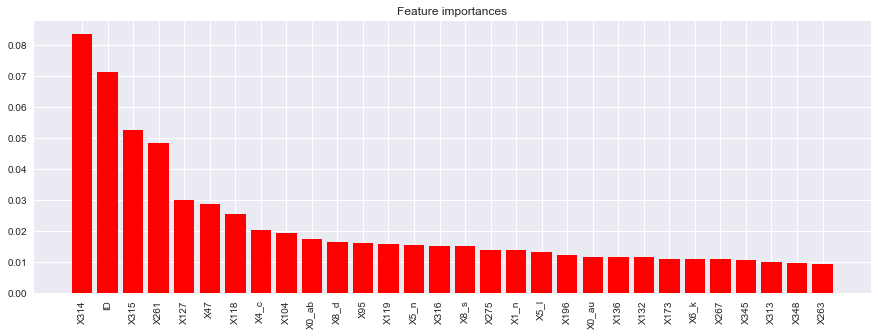

In [42]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

GBmodel = GradientBoostingRegressor(learning_rate=0.1, n_estimators=77,  random_state=0, # tuned on all data
                                    max_depth=3, min_samples_split=10, min_samples_leaf=1, 
                                    max_features=150, subsample=1)

GBpreds, score = fitit(GBmodel)
features(GBmodel)

### Scikit-optimize on sklearn GradientBoostingRegressor

In [43]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize

def objective(params):
    lr = 10.0 ** params[0]
    nest =  params[1]
    maxd =  params[2]
    minss = params[3]
    maxf =  params[4]
    minsl = params[5]
    GBmodel = GradientBoostingRegressor(learning_rate=lr, n_estimators=nest,  random_state=0,
                                        max_depth=maxd, min_samples_split=minss, min_samples_leaf=minsl, 
                                        max_features=maxf, subsample=1)
    results = cross_val_score(GBmodel, Xtrain, ytrain, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    return -np.mean(results)

In [44]:
%%time
space = [(-5.0, 0.0), # learning_rate
         (20, 800), # n_estimators
         (1, 6),  # max_depth
         (2, 100), # min_samples_split
         (1, Xtrain.shape[1]), # max_features
         (1, 20),  # min_samples_leaf
        ]

r = gp_minimize(objective, space, n_calls=200, random_state=0)
print(r.x)

[-1.5850655826815125, 259, 2, 35, 513, 17]
CPU times: user 14min 33s, sys: 40.9 s, total: 15min 14s
Wall time: 22min 21s


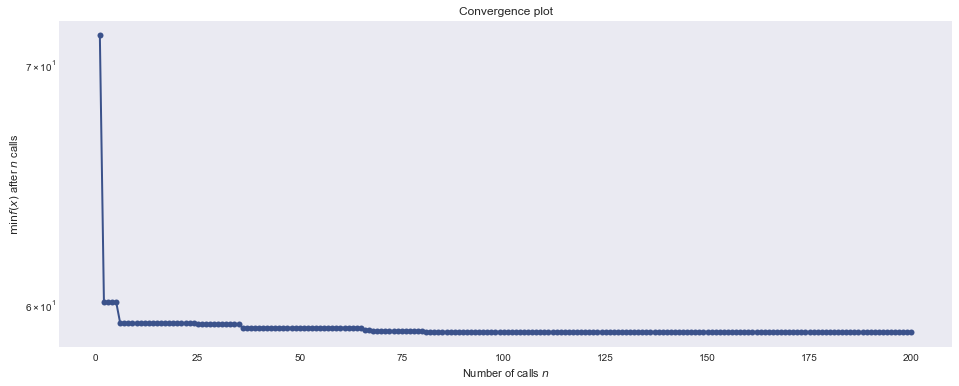

In [45]:
from skopt.plots import plot_convergence
_ = plt.figure(figsize=(16,6))
_ = plot_convergence(r, yscale='log')

Train R2 score= 0.62342
Test  R2 score= 0.63897

Predictions saved to file: Preds_GBmodel.csv


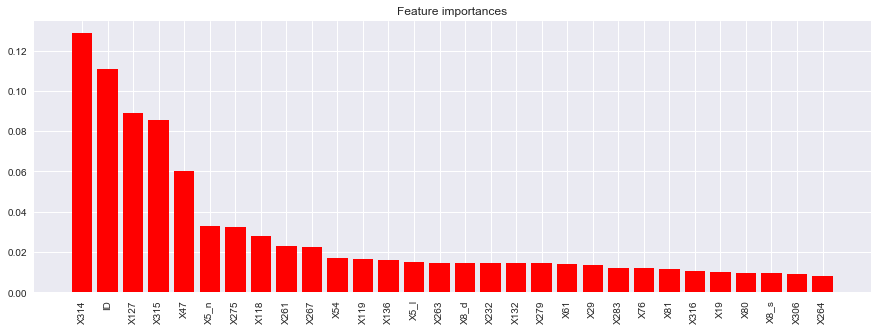

In [46]:
GBmodel = GradientBoostingRegressor(learning_rate=10**-1.5850655826815125, n_estimators=259,  random_state=0,
                                    max_depth=2, min_samples_split=35, max_features=513, min_samples_leaf=17, 
                                     subsample=1)

GBpreds, score = fitit(GBmodel)
features(GBmodel)

In [8]:
%%time
# try random search to improve above gradient boosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# params = {'n_estimators':  np.linspace(10, 100, 10).astype(int),
#           'learning_rate': np.linspace(0.1, 0.4, 5),
#           'max_features':  np.linspace(0.2, 0.9, 5),
#           'max_depth':     [1,2,3,],
#           'min_samples_leaf': [2,3,],
#           'min_samples_split': [2,3,],
#           'subsample':     [0.93, 0.95, 0.97]
#          }

params = {'learning_rate': [0.1],
          'n_estimators':  [77], # tuned on full data 77
          'max_depth':     [3], # tuned on full data 3
          'min_samples_split': [10], # tuned on full data 10
          'min_samples_leaf' : [1], # tuned on full data 1
          'max_features':  [150], # tuned on full data 150
          'subsample':     [1],   # tuned on full data 1
         }

GBmodel = GridSearchCV(GradientBoostingRegressor(random_state=0), 
                       cv=10, n_jobs=-1, param_grid=params, verbose=1)
GBpreds, score = fitit(GBmodel, saveit=False)

print('BEST', GBmodel.best_params_)
print(GBmodel.best_estimator_)


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.9s finished


BEST {'n_estimators': 77, 'min_samples_leaf': 1, 'min_samples_split': 10, 'max_features': 150, 'subsample': 1, 'max_depth': 3, 'learning_rate': 0.1}
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=150,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=77, presort='auto',
             random_state=0, subsample=1, verbose=0, warm_start=False)
CPU times: user 1.38 s, sys: 113 ms, total: 1.49 s
Wall time: 4.23 s


### XGBoost (very good!)

In [1]:
%%time
# Tuning Approach
# set all params to default (incl learning rate=0.1)
# tune min_child_weight and max_depth together for [1,2,3,4,5,6]
# tune gamma from 0-1
# tune subsample and colsample_bytree around 0.5-1
# tune reg_alpha, reg_lambda from 0-20

import xgboost as xgb
from sklearn.metrics import r2_score

# params = { # original params from kaggle example
#     'n_trees': 500, # param likely not used
#     'eta': 0.005, # 0.01-0.2 but 0.1 is recommended
#     'max_depth': 4, # 3-6
#     'subsample': 0.95, # 0.5-1
#     'objective': 'reg:linear', # correct as is
#     'eval_metric': 'rmse',
#     'base_score': np.mean(ytrain), # base prediction = mean(target)
#     'silent': 1
# }

params = {
    'learning_rate': 0.042, # 0.6752 submitted with LR0.04, Lr0.042 = 0.67728 (best on kaggle)
    'min_child_weight': 1, 
    'max_depth': 5, 
    'gamma': 0, 
    'subsample': 0.95,
    'colsample_bytree': 1, 
    'reg_alpha':  0, 
    'reg_lambda': 1,
    'eval_metric': 'rmse',
    'base_score': np.mean(ytrain), # base prediction = mean(target)
}

dtrain = xgb.DMatrix(Xtrain, ytrain) # train on train subset of training data

cv_result = xgb.cv(params, dtrain, num_boost_round=9000, early_stopping_rounds=50,
                   nfold=10, verbose_eval=50, show_stdv=False)

XBmodel = xgb.train(dict(params, silent=0), dtrain, num_boost_round=cv_result.shape[0])

XBtpreds = XBmodel.predict(dtrain)
print('\nR2 for training  ', r2_score(dtrain.get_label(), XBtpreds))

dvalid = xgb.DMatrix(Xvalid)
XBvpreds = XBmodel.predict(dvalid)
print('R2 for validation', r2_score(yvalid, XBvpreds))

dtest = xgb.DMatrix(Xtest)
XBpreds = pd.DataFrame({'ID': Xtest.ID, 'y': XBmodel.predict(dtest)})
XBpreds.to_csv('Preds_XGBoostModel.csv', index=False)
print('Number of estimators', cv_result.shape[0])

_ = plt.figure(figsize=(18,5))
feat_imp = pd.Series(XBmodel.get_fscore()).sort_values(ascending=False)[:30]
_=feat_imp.plot(kind='bar', title='Feature Importances')
_=plt.ylabel('Feature Importance Score')

OSError: dlopen(/Users/graham/anaconda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/gcc/lib/gcc/7/libgomp.1.dylib
  Referenced from: /Users/graham/anaconda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/libxgboost.dylib
  Reason: image not found

In [16]:
%%time
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

params = {
      'min_child_weight': [1], # 9 full tune, 3 initial tune
      'max_depth': [4], # 1 full tune, 2 initial tune
      'gamma': np.linspace(0, 0.07, 3), # 0 full tune 0.03 initial tune
      'subsample': np.linspace(0.8, 1, 3), # initial tune 0.92,
      'colsample_bytree': np.linspace(0.1, 0.8, 5), # initial tune 0.82,
      'reg_alpha':  np.linspace(0, 2, 3), 
      'reg_lambda': np.linspace(5, 15, 5),
}

# XGmodel = xgb.XGBRegressor(learning_rate=0.1, n_estimators=1000, min_child_weight=3, max_depth=2, gamma=0, 
#                        subsample=0.92, colsample_bytree=0.82, reg_alpha=2.4, reg_lambda=2.8,
#                        base_score=np.mean(ytrain), random_state=0) # tuned on 80% of data

XGmodel = xgb.XGBRegressor(learning_rate=0.06, n_estimators=1000, min_child_weight=9, max_depth=1, gamma=0, 
                       subsample=1, colsample_bytree=0.23, reg_alpha=0, reg_lambda=1,
                       base_score=np.mean(ytrain), random_state=0,n_jobs=1) 

#XGmodel = GridSearchCV(XGmodel, cv=10, param_grid=params, verbose=2)
XGmodel = RandomizedSearchCV(XGmodel, cv=10, n_iter=150, n_jobs=-1, param_distributions=params, verbose=10)
XGpreds, score = fitit(XGmodel, saveit=False)

print(XGmodel.best_estimator_)
print(XGmodel.best_params_)
#print()
#print(XGmodel.cv_results_)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0 
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0 
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0 
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0 
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0 
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0 
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0 
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=0.0, min_child_we

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min


[CV] subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.621440, total= 1.3min
[CV] subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0 
[CV] subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.590927, total=  57.8s
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.686296, total=  57.9s
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.537644, total=  58.0s
[CV]  subsample=0.9, max

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.3min


[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.558304, total= 1.3min
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.632507, total= 1.3min
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0 


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.6min


[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.512418, total=  59.1s
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.481902, total=  59.1s
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.646078, total=  59.0s
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0 
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0 
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.553985, total=  59.5s
[CV] subsample=0.9, max_depth=4, g

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.5min


[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0, score=0.517480, total= 1.3min
[CV] subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0, score=0.556387, total= 1.3min
[CV] subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0, score=0.639585, total= 1.3min
[CV] subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5, score=0.543174, total= 1.3min
[CV] subsample=0.9, max_depth=4, gamma=0.035, 

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.7min


[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5, score=0.629709, total= 1.2min
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.556968, total=  14.7s
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.695359, total=  14.7s
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5, score=0.476732, total= 1.2min
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5, score=0.513277, total= 1.2min
[CV]  subsample=

[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.2min


[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.636022, total=  15.2s
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5, score=0.552916, total= 1.2min
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5, score=0.638426, total= 1.2min
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0, score=0.545927, total=  15.3s
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsampl

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.5min


[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0, score=0.492428, total=  15.4s
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0, score=0.511157, total=  15.5s
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0, score=0.559136, total=  14.6s
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0, score=0.636963, total=  14.5s
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsa

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.0min


[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0, score=0.544672, total= 1.3min
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0, score=0.688564, total= 1.3min
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0, score=0.584658, total= 1.3min
[CV] subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0, score=0.599408, total= 1.3min
[CV] subsample=1.0, max_depth=4, gamma=0.0, cols

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.2min


[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0, score=0.624423, total= 1.2min
[CV] subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0, score=0.552006, total=  27.4s
[CV] subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0, score=0.689092, total=  27.4s
[CV] subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0, score=0.626015, total=  52.1s
[CV] subsample=0.9, max_depth=4, 

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 11.5min


[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0, score=0.503010, total=  27.9s
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0, score=0.557064, total=  27.3s
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0, score=0.634683, total=  27.4s
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5, score=0.543635, total=  41.4s
[CV] subsample=0.9, max_depth=4, gamma=0.

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 12.4min


[CV] subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0, score=0.508532, total=  13.2s
[CV] subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0, score=0.530411, total=  13.2s
[CV] subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5, score=0.549291, total=  42.1s
[CV] subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.4

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 13.2min


[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5, score=0.693796, total=  14.1s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5, score=0.602671, total=  14.1s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5, score=0.609907, total=  14.1s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0, score=0.566571, total=  26.2s
[CV] subsample=0.8, max_depth=4, gamma=0.0, col

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 13.7min


[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0, score=0.499545, total=  14.1s
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0, score=0.521043, total=  14.1s
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0, score=0.565297, total=  14.0s
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0, score=0.636340, total=  14.0s
[CV] subsample=0.8, max_depth=4, gamma=0.0, col

[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 15.4min


[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=7.5, score=0.626915, total= 1.1min
[CV] subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.1, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.1, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0, score=0.561940, total=  13.0s
[CV] subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.1, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.1, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0, score=0.691537, total=  13.0s
[CV] subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.1, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.1, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0, score=0.606344, total=  12.9s
[CV] subsample=1.0, max_depth=4, gamma=0.03

[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 16.1min


[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5, score=0.505439, total=  13.0s
[CV] subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5, score=0.528256, total=  13.1s
[CV] subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5, score=0.567604, total=  13.0s
[CV] subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5, score=0.635235, total=  13.0s
[CV] subsample=1.0, max_depth=4, gamma=0.0, co

[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed: 17.8min


[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0, score=0.509620, total=  13.9s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0, score=0.557989, total=  14.1s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0, score=0.633372, total=  14.1s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=12.5, score=0.555826, total=  14.1s
[CV] subsample=0.8, max_depth=4, gamma=0.07, c

[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed: 19.0min


[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5, score=0.512262, total=  42.0s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5, score=0.683117, total=  27.8s
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5, score=0.553566, total=  27.9s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5 
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5, score=0.591631, total=  27.9s
[CV] subsample=0.8, max_depth=4, gam

[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed: 21.1min


[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.690829, total=  27.5s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.596944, total=  27.6s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.606988, total=  27.6s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.629994, total=  27.5s
[CV] subsample=0.8, max_depth

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 23.9min


[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0, score=0.596410, total= 1.1min
[CV] subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0, score=0.621710, total= 1.1min
[CV] subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0, score=0.623317, total= 1.1min
[CV] subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0, score=0.625726, total= 1.1min
[CV] subsample=0.9, max_depth=4, gamma=

[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed: 26.8min


[CV]  subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.45, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0, score=0.630788, total=  41.6s
[CV]  subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.45, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0, score=0.542052, total=  41.7s
[CV] subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0 
[CV] subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0, score=0.544901, total=  41.0s
[CV] subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0, score=0.680118, total=  41.0s
[CV] subsample=0.9, max_depth=4, gam

[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed: 28.6min


[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.593454, total=  42.5s
[CV] subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.606668, total=  42.4s
[CV] subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.626050, total=  42.6s
[CV] subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.622844, total=  42.7s
[CV] subsample=0.9, max_depth

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 30.1min


[CV]  subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.547337, total= 1.1min
[CV]  subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.699340, total= 1.1min
[CV] subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0 
[CV] subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.626378, total= 1.1min
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.600991, total= 1.1min
[CV] subsample=0.9, max_depth=4, gamma=0.0

[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed: 32.2min


[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0, score=0.497098, total=  13.8s
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0, score=0.514299, total=  13.9s
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0, score=0.562276, total=  13.7s
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0, score=0.640078, total=  13.7s
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsam

[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 35.9min


[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5, score=0.606849, total=  13.1s
[CV] subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5, score=0.618379, total=  13.1s
[CV] subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=12.5, score=0.629022, total= 1.1min
[CV] subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=0.0, min_child_weight=1, reg_lambda=12.5, score=0.617201, total= 1.1min
[CV] subsample=0.9, max_depth=4, gamma=0.07, 

[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 37.2min


[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5, score=0.636557, total=  25.6s
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5, score=0.620840, total=  25.7s
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5, score=0.500789, total=  25.7s
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5, score=0.533441, total=  25.6s
[CV] subsample=0.8, max_depth=4

[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed: 39.4min


[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0, score=0.620752, total=  26.9s
[CV] subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0, score=0.491234, total=  27.1s
[CV] subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0, score=0.510884, total=  26.9s
[CV] subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0, score=0.559070, total=  27.0s
[CV] subsample=1.0, max_depth=4,

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 41.3min


[CV]  subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0, score=0.497125, total=  38.6s
[CV]  subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0, score=0.524250, total=  38.5s
[CV] subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0 
[CV] subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0, score=0.559951, total=  25.4s
[CV] subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0, score=0.694462, total=  25.6s
[CV] subsample=1.0, max_depth=4, gamma=0

[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed: 43.8min


[CV]  subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0, score=0.544340, total=  38.2s
[CV] subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0, score=0.687306, total=  38.5s
[CV] subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0, score=0.599773, total=  38.5s
[CV] subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0, score=0.616897, total=  38.5s
[CV] subsample=1.0, max_depth=4, gamma=0.0, c

[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed: 46.8min


[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0, score=0.491367, total=  51.6s
[CV] subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0, score=0.520748, total=  51.7s
[CV] subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.507896, total=  12.8s
[CV] subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.528947, total=  12.7s
[CV] subsample=1.0, max_depth=4, gamma

[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed: 48.9min


[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0, score=0.521304, total=  13.5s
[CV] subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0, score=0.564692, total=  13.5s
[CV] subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0, score=0.638662, total=  13.5s
[CV] subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=12.5, score=0.545749, total=  40.6s
[CV]  subsample=0.9, max_depth=4, gamma=0.

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 51.7min


[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.603258, total=  55.2s
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.589672, total=  55.3s
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.621197, total=  55.4s
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.615817, total=  55.3s
[CV] subsample=0.8, max_depth=

[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 55.8min


[CV] subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0, score=0.545346, total=  54.1s
[CV] subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0, score=0.681048, total=  54.1s
[CV] subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0, score=0.583786, total=  54.2s
[CV] subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytr

[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 58.5min


[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0, score=0.555947, total=  41.3s
[CV] subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5, score=0.561263, total=  13.6s
[CV] subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.1, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5, score=0.640466, total=  13.6s
[CV] subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0, score=0.644597, total=  41.4s
[CV] subsample=1.0, max_depth=4, gamma=0.0, 

[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed: 62.2min


[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0, score=0.617278, total= 1.2min
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0, score=0.477219, total= 1.2min
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=2.0, min_child_weight=1, reg_lambda=15.0, score=0.509060, total= 1.2min
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0, score=0.550529, total=  59.2s
[CV] subsample=0.8, max_depth=4, ga

[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 65.6min


[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.629641, total=  29.3s
[CV] subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.615067, total=  29.3s
[CV] subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.488361, total=  29.5s
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.512502, total=  29.4s
[CV] subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5 
[CV] subsample=1.0, max_depth=4, gamma=

[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed: 70.3min


[CV]  subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5, score=0.511889, total=  15.4s
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.556477, total= 1.0min
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.648433, total= 1.0min
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5, score=0.559651, total=  15.2s
[CV] subsample=0.9, max_depth=4, gamma=0.0,

[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 72.9min


[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.486087, total=  44.6s
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.516544, total=  44.8s
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.551462, total=  45.7s
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=15.0, score=0.637302, total=  45.8s
[CV] subsample=0.8, max_depth=4, g

[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed: 76.3min


[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=12.5, score=0.639619, total=  15.7s
[CV] subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0, score=0.553834, total=  53.5s
[CV] subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0, score=0.678165, total=  53.4s
[CV] subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0, score=0.588132, total=  52.9s
[CV] subsample=0.9, max_depth=4, gamm

[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed: 81.1min


[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0, score=0.599958, total=  28.8s
[CV] subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0, score=0.606451, total=  28.9s
[CV] subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0, score=0.630790, total=  28.8s
[CV] subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0, score=0.620521, total=  29.0s
[CV] subsample=0.9, max_d

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 84.5min


[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0, score=0.509584, total=  48.1s
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0, score=0.545008, total=  48.0s
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=5.0, score=0.639148, total=  47.8s
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5 
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5, score=0.551169, total= 1.1min
[CV] subsample=0.9, max_depth=4, gamma=0.0,

[Parallel(n_jobs=-1)]: Done 1042 tasks      | elapsed: 88.7min


[CV]  subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.647122, total=  18.0s
[CV] subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.620841, total=  18.2s
[CV] subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.507534, total=  18.2s
[CV] subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=1.0, max_depth=4, gamma=0.07, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.529215, total=  18.1s
[CV] subsample=1.0, max_depth=4, g

[Parallel(n_jobs=-1)]: Done 1089 tasks      | elapsed: 93.3min


[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5, score=0.505725, total=  31.2s
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5, score=0.556199, total=  30.4s
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=7.5, score=0.641249, total=  30.5s
[CV] subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.1, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0, score=0.606473, total=  15.7s
[CV] subsample=0.9, max_depth=4, gamma=0.07, colsam

[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 98.6min


[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0, score=0.489501, total=  29.7s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0, score=0.511416, total=  29.7s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0, score=0.559027, total=  29.7s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=2.0, min_child_weight=1, reg_lambda=7.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0, score=0.641040, total=  29.7s
[CV] subsample=0.8, max_depth=4, gamma=

[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed: 104.8min


[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0, score=0.626140, total=  46.0s
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0, score=0.479988, total=  45.0s
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0, score=0.508431, total=  45.1s
[CV] subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=1.0, min_child_weight=1, reg_lambda=5.0, score=0.548426, total=  44.2s
[CV] subsample=0.9, max_depth=4, gamma=0

[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 109.7min


[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=12.5, score=0.553804, total=  58.6s
[CV]  subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=1.0, min_child_weight=1, reg_lambda=12.5, score=0.651011, total=  58.1s
[CV] subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0 
[CV] subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=7.5, score=0.499878, total=  29.4s
[CV] subsample=1.0, max_depth=4, gamma=0.035, colsample_bytree=0.8, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=1.0, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=7.5, score=0.531829, total=  29.5s
[CV] subsample=1.0, max_depth=4, g

[Parallel(n_jobs=-1)]: Done 1285 tasks      | elapsed: 115.5min


[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0, score=0.619424, total=  30.3s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0, score=0.489391, total=  27.4s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0, score=0.506470, total=  27.3s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.275, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0, score=0.559721, total=  27.3s
[CV] subsample=0.8, max_depth=4,

[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed: 121.5min


[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5, score=0.483892, total= 1.0min
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5, score=0.512081, total= 1.0min
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5, score=0.557675, total= 1.0min
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=10.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.0, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=12.5, score=0.640944, total= 1.0min
[CV] subsample=0.8, max_depth=

[Parallel(n_jobs=-1)]: Done 1389 tasks      | elapsed: 127.4min


[CV]  subsample=0.9, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=0.0, min_child_weight=1, reg_lambda=7.5, score=0.639874, total=  43.6s
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.549197, total= 1.2min
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.691898, total= 1.2min
[CV] subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.8, reg_alpha=1.0, min_child_weight=1, reg_lambda=15.0, score=0.579548, total= 1.2min
[CV] subsample=0.8, max_depth=4, gamma=0.03

[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 132.4min


[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=7.5, score=0.626639, total=  28.4s
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.9, max_depth=4, gamma=0.0, colsample_bytree=0.275, reg_alpha=0.0, min_child_weight=1, reg_lambda=7.5, score=0.621106, total=  28.2s
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0, score=0.547210, total=  43.7s
[CV] subsample=0.8, max_depth=4, gamma=0.035, colsample_bytree=0.625, reg_alpha=2.0, min_child_weight=1, reg_lambda=5.0 
[CV]  subsample=0.8, max_depth=4, gamma=0.07, colsample_bytree=0.45, reg_alpha=1.0, min_child_weight=1, reg_lambda=10.0, score=0.636383, total=  43.5s
[CV] subsample=0.8, max_depth=4, ga

[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 138.0min finished


XGBRegressor(base_score=100.52666666666657, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=0.10000000000000001,
       gamma=0.035000000000000003, learning_rate=0.06, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=2.0, reg_lambda=15.0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)
{'subsample': 1.0, 'max_depth': 4, 'gamma': 0.035000000000000003, 'colsample_bytree': 0.10000000000000001, 'reg_alpha': 2.0, 'min_child_weight': 1, 'reg_lambda': 15.0}
CPU times: user 53.9 s, sys: 3.92 s, total: 57.8 s
Wall time: 2h 18min 5s


In [11]:
print(XGmodel.best_score_)

0.612369079878


## Elasticnet (good!)

Train R2 score= 0.62578
Test  R2 score= 0.54738

Predictions saved to file: Preds_ENmodel.csv

Optimal alpha: 0.02447368
Optimal l1_ratio: 0.9895
Number of iterations 897
114 features, reduction of 80.31%
CPU times: user 1min 44s, sys: 5.06 s, total: 1min 49s
Wall time: 15.9 s


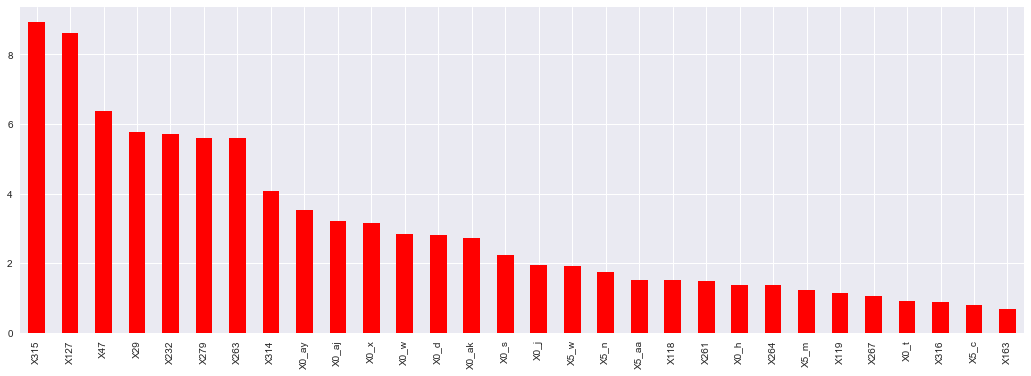

In [45]:
%%time
from sklearn.linear_model import ElasticNetCV

# cv_model = ElasticNetCV(l1_ratio=[.1, .5, .99, .995, .998, .9985, .999, .9995, 1], eps=0.001, n_alphas=500, 
#                         fit_intercept=True, normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=5, 
#  old and best           copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')

alphas = np.linspace(0.015, 0.03, 20)
l1_ratio = np.linspace(0.95, 1, 20)

ENmodel = ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas, max_iter=10000, cv=10, n_jobs=-1, random_state=0)

ENpreds, score = fitit(ENmodel)

print('\nOptimal alpha: %.8f'%ENmodel.alpha_)
print('Optimal l1_ratio: %.4f'%ENmodel.l1_ratio_)
print('Number of iterations %d'%ENmodel.n_iter_)

feature_importance = pd.Series(index = Xtrain.columns, data = np.abs(ENmodel.coef_)) # .drop('ID',1)

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

_ = feature_importance.sort_values(ascending=False).head(30).plot(kind='bar', color="r", figsize = (18,6))

## KNN Regressor (terrible!)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

KNNmodel = KNeighborsRegressor(n_neighbors = 3)
KNNpreds, score = fitit(KNNmodel)

## Linear Regression (badly affected by correlations!)
Corellations make coeffs huge

In [ ]:
from sklearn.linear_model import LinearRegression

LRmodel = LinearRegression()
LRpreds, score = fitit(LRmodel)

## Ridge Regression (Good!)

In [ ]:
from sklearn.linear_model import RidgeCV, Ridge

params = [{ 'alpha': np.linspace(36, 40, 40)}]

#RRmodel = GridSearchCV(Ridge(), cv=5, n_jobs=-1, param_grid=params)
#RRmodel = RidgeCV(cv=5, alphas=params[0]['alpha'])
RRmodel = Ridge(alpha=36.615, random_state=1)

RRpreds,score = fitit(RRmodel)

## LASSO Regression (Good!)

In [ ]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import GridSearchCV

params = [{ 'alpha': np.linspace(0.01, 0.03, 20)}]

#LAmodel = Lasso(alpha=0.02473,max_iter=5000, random_state=1)
#LAmodel = GridSearchCV(Lasso(max_iter=5000), cv=5, n_jobs=-1, param_grid=params)

LAmodel = LassoCV(cv=5, max_iter=5000, alphas=params[0]['alpha'], n_jobs=-1, random_state=1)

LApreds, score = fitit(LAmodel)

print('\nOptimal alpha: %.8f'%LAmodel.alpha_)
print('\nNumber of coefficients > zero=', len(LAmodel.coef_[abs(LAmodel.coef_) > 0]))

### Extra PCA feature on  Lasso regression (doesnt improve over Lasso)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Xtrain_n = StandardScaler().fit_transform(Xtrain)
Xvalid_n = StandardScaler().fit_transform(Xvalid)

for comps in np.linspace(78,79,1).astype(int):
    pca = PCA(n_components = comps, random_state=1).fit(Xtrain_n)
    Xtrain_pca = pca.transform(Xtrain_n)
    Xvalid_pca = pca.transform(Xvalid_n)

    Xtrain_pca = np.append(Xtrain, Xtrain_pca, axis=1)
    Xvalid_pca = np.append(Xvalid, Xvalid_pca, axis=1)

#     Xtrain_pca=Xtrain
#     Xvalid_pca=Xvalid

    RRPCAmodel = LAmodel
    #fitit(RRPCAmodel)
    
    RRPCAmodel.fit(Xtrain_pca, ytrain)

    RRPCAtpreds = RRPCAmodel.predict(Xtrain_pca)
    RRPCAvpreds = RRPCAmodel.predict(Xvalid_pca)
    print('Training R2 Score  ', r2_score(ytrain, RRPCAtpreds), comps)
    print('Validation R2 score', r2_score(yvalid, RRPCAvpreds), comps)

Xtrain.shape
Xtrain_n.shape
Xtrain_pca.shape

In [ ]:
# pca.components_.T[0]
# pca.explained_variance_ratio_

In [ ]:
# # MUST SET PCA N_COMPONENTS = 2!!!
# _ = plt.figure(figsize=(10,10))
# cm = plt.cm.get_cmap('RdYlBu')
# color =(Xtrain - np.min(Xtrain)) / (np.max(Xtrain) - np.min(Xtrain)) * 255
# ax = plt.scatter(Xtrain_pca[:,0], Xtrain_pca[:,1], c=color, cmap=cm )
# _ = plt.colorbar(ax)

### t-SNE

In [ ]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0)
Xtsne = tsne.fit_transform(Xtrain)

_ = plt.figure(figsize=(12,10))
cm = plt.cm.get_cmap('RdYlBu')
color = ytrain
ax = plt.scatter(Xtsne[:,0], Xtsne[:,1], c=color, cmap=cm )
_ = plt.colorbar(ax)

## Averages of Classifiers
Try different model combinations

In [ ]:
results = pd.concat([RFpreds,GBpreds,ENpreds, RRpreds, LApreds, XGpreds, XBpreds], axis=1)
results.columns = ['ID','RFpreds','X1','GBpreds','X1','ENpreds','X1','RRpreds',
                   'X1','LApreds','X1','XGpreds', 'X1','XBpreds']
results.drop(['X1'], axis=1, inplace=True) # drop RR as is much more often the outlier

In [ ]:
results['average'] = results[['RFpreds','GBpreds','ENpreds','LApreds','XGpreds','XBpreds']].mean(axis=1)
results['RFm'] = (results.RFpreds - results.average).abs()
results['GBm'] = (results.GBpreds - results.average).abs()
results['ENm'] = (results.ENpreds - results.average).abs()
results['RRm'] = (results.RRpreds - results.average).abs()
results['LAm'] = (results.LApreds - results.average).abs()
results['XGm'] = (results.XGpreds - results.average).abs()
results['XBm'] = (results.XBpreds - results.average).abs()
results['Max'] = results[['RFm','GBm','ENm','RRm', 'LAm','XGm','XBm']].idxmax(axis=1)

results.Max.value_counts(dropna=False)

results.head(20)

In [ ]:
for i in range(results.index.min(), results.index.max()+1):
    row = results.loc[i]
    result = row.average # set default
    if row.Max == 'RFm':
        result = np.mean([row.GBpreds, row.ENpreds,  row.LApreds, row.XGpreds, row.XBpreds])
    if row.Max == 'GBm':
        result = np.mean([row.RFpreds, row.ENpreds,  row.LApreds, row.XGpreds, row.XBpreds])
    if row.Max == 'ENm':
        result = np.mean([row.RFpreds, row.GBpreds,  row.LApreds, row.XGpreds, row.XBpreds])
    if row.Max == 'LAm':
        result = np.mean([row.RFpreds, row.GBpreds, row.ENpreds, row.XGpreds, row.XBpreds])
    if row.Max == 'XGm':
        result = np.mean([row.RFpreds, row.GBpreds, row.ENpreds, row.LApreds, row.XBpreds])
    if row.Max == 'XBm':
        result = np.mean([row.RFpreds, row.GBpreds, row.ENpreds, row.LApreds, row.XGpreds])
    results.loc[i, 'final'] = result

In [ ]:
output = pd.DataFrame({'ID': results.ID.astype(np.int32), 'y': results.final})
output.to_csv('Preds_Final.csv', index=False)

# output = pd.DataFrame({'ID': test['ID'].astype(np.int32), 'y': (XGfpreds + ENfpreds + RFfpreds)/3})
# output.to_csv('PredsENandXGBandRF.csv', index=False)